# 链接仪器

In [102]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab import wavepoint
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new, measureroutine_new
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
mn = imp.reload(measureroutine_new)
wf = imp.reload(wavepoint)

In [2]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
# ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
psg104 = await connect('PSG104')
psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

In [96]:
await psg103.setValue('Output','OFF')

# qubit工作点

In [3]:
freqall = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.607,6.63])*1e9
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}
atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=-0.023,f_ex=2*6.3e9+2e6,power_ex=-2.55) #power=-2.1

## 保存工作点

In [206]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0503\QubitState\qubitstate_20200503163045.npz


## 提取工作点

In [11]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0503\QubitState\qubitstate_20200503163045.npz


# 指定仪器

In [4]:
psg_lo = psg104
psg_ex1 = psg105
psg_ex2 = psg106
psg_ex3 = psg103
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_ex2':psg_ex2,'psg_ex3':psg_ex3,'psg_pump':psg_pump}
ats = ats18
awg_trig = awg100
dc = {'dc01':dc01,'dc02':dc02,'dc03':dc03,'dc05':dc05,'dc06':dc06,\
      'dc07':dc07,'dc08':dc08,'dc10':dc10,'dc11':dc11,'dc15':dc15,'dc20':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133}

## 测量类

In [5]:
measure = mr.common(freqall,ats,dc,psg,awg_list,jpa)

In [6]:
await mr.awgSync(measure)

# 信号检查

In [75]:
delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
       9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
delta = np.array([50e6])
await cw.modulation_read(measure,delta,tdelay=1400)
# await mr.ats_setup(ats,delta,l=180+128)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

<qulab.waveform_new.Waveform object at 0x0000020E934DEC48> <qulab.waveform_new.Waveform object at 0x0000020E934DEDC8>


array([50000000.])

In [78]:
await cw.modulation_ex(q1,measure)

In [150]:
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

## 复平面信号

<IPython.core.display.Javascript object>


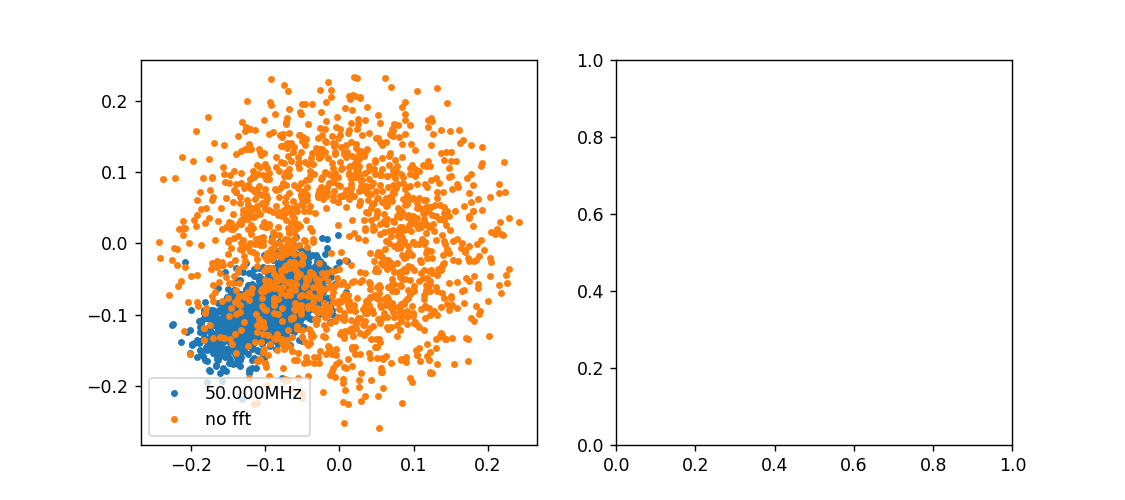

In [145]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=True,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

<IPython.core.display.Javascript object>


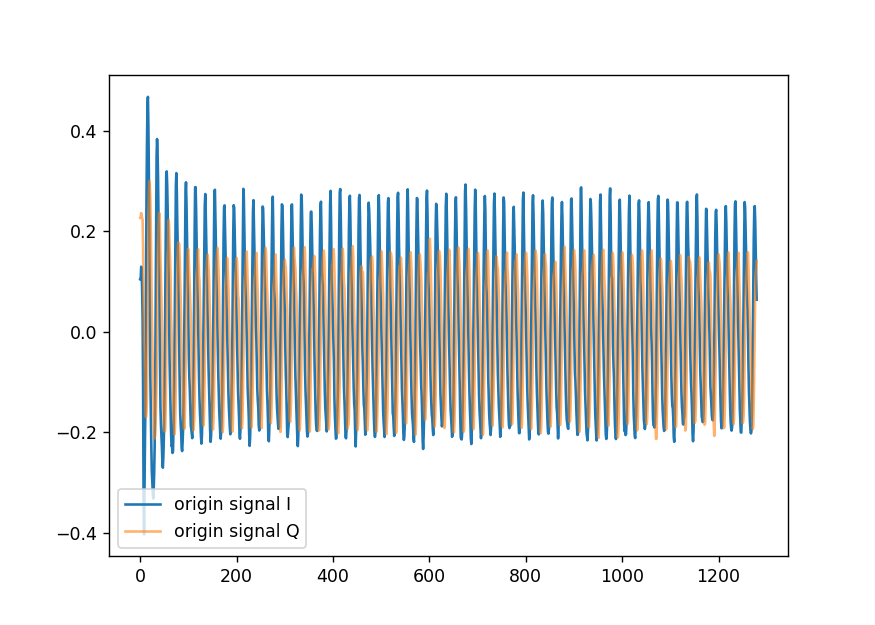

In [8]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex2'].setValue('Output','OFF')
for i in range(1):
    chA, chB = await ats.getTraces()
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


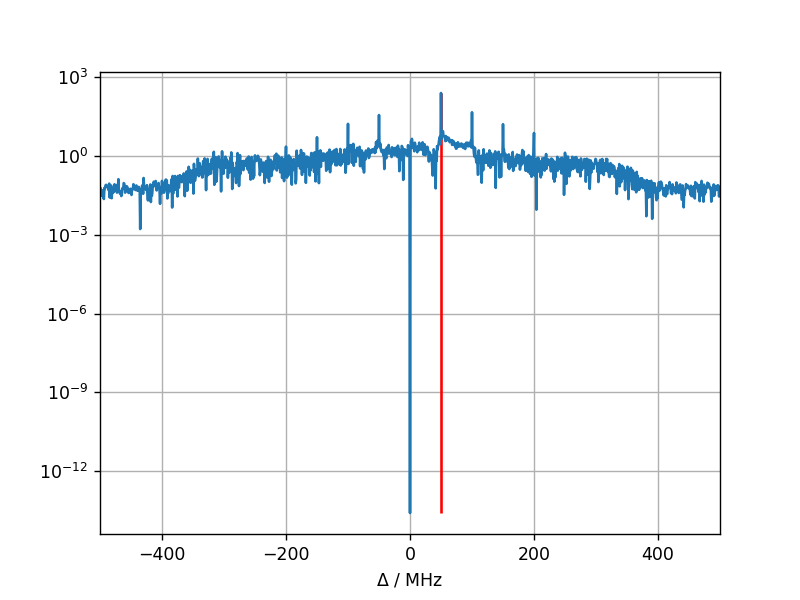

In [9]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

# 仪器状态

In [82]:
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=['awg131','awg132','awg133','awg134'])

In [30]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,0,0,0,0,+0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.554980GHz,3.891000GHz,4.049000GHz,6.611080GHz,12.602000GHz
load,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0
offset,1,0,-0.023,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,1
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000dBm,0.000000dBm,13.000000dBm,18.000000dBm,-2.550000dBm


In [142]:
await psg_ex1.setValue('Power',10)

In [143]:
await mr.RecoverInst(measure)

In [197]:
await psg_ex1.setValue('Output','OFF')

In [139]:
await psg_lo.setValue('Frequency',6.055e9)

In [49]:
for i in range(100):
    await psg_lo.query('syst:err?')

In [42]:
for i in dc:
    await dc[i].setValue('Load','High')

In [30]:
qname = ['testI','testQ']
awg = awg133
l = 64*10
length = l*2.5
t_new = np.linspace(-l,0,length)*1e-9
await awg.create_waveform(name=qname[0], length=len(t_new), format=None)
await awg.create_waveform(name=qname[1], length=len(t_new), format=None)
await awg.use_waveform(name=qname[0],ch=5)
await awg.use_waveform(name=qname[1],ch=6)
await mr.ats_setup(ats,delta,l=l)
pulse = await cw.rabiWave(envelopename='cospulse',nwave=1,amp=1,during=(l-400)/2e9,Delta_lo=150e6)
await cw.writeWave(awg,qname,pulse,t_new)
await mr.couldRun(awg)

# S21

In [87]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10],q_target='q3')

com7 open...
last ATT 08.0
now ATT 13.0


Output()

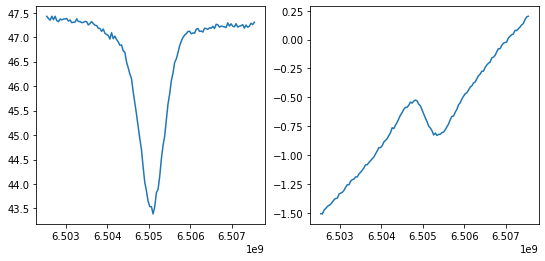

In [12]:
q_target = q1
tag = q_target.q_name
att_setup = mr.Att_Setup(measure,'com7')
att_setup.Att(13)
await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
await mr.jpa_switch(measure,state='ON')
job = Job(mr.S21, (q_target,measure,True), tags=[tag], max=126)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

com7 open...
last ATT 13.0
now ATT 12.0


Output()

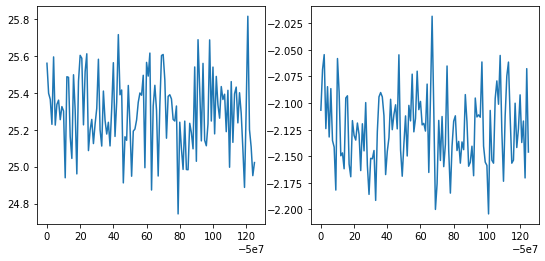

In [36]:
att_setup = mr.Att_Setup(measure,'com7')
att_setup.Att(12)
await psg_lo.setValue('Output','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
await mr.jpa_switch(measure,state='ON')
job = Job(mr.test, (measure,126), tags=[tag], max=126)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [38]:
await psg_lo.query('syst:err?')

'0,"No error"\n'

# S21vsFlux

In [81]:
current = np.linspace(-2,2,21)
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
#await dc[bis[0].inst['dc']].DC(1)
for i in bits[3:5]:
    tag = i.q_name
    print(tag)
    await mr.jpa_switch(measure,'ON')
    await awg133.output_on(ch=7)
    await awg133.output_on(ch=8)
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mr.S21vsFlux, (qubits,measure,current,1,True), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

q4


Output()

q5


Output()

In [ ]:
calimatrix = np.load(r'D:/QuLabData/2020/0401/crosstalk_cali/xue_crosstalk_q2_5_20200401211425.npz')['mat']
calimatrix[1:5,1:5]

In [ ]:
calimatrix = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [ ]:
calimatrix[1:5,1:5]

# S21vsPower

In [ ]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

<IPython.core.display.Javascript object>


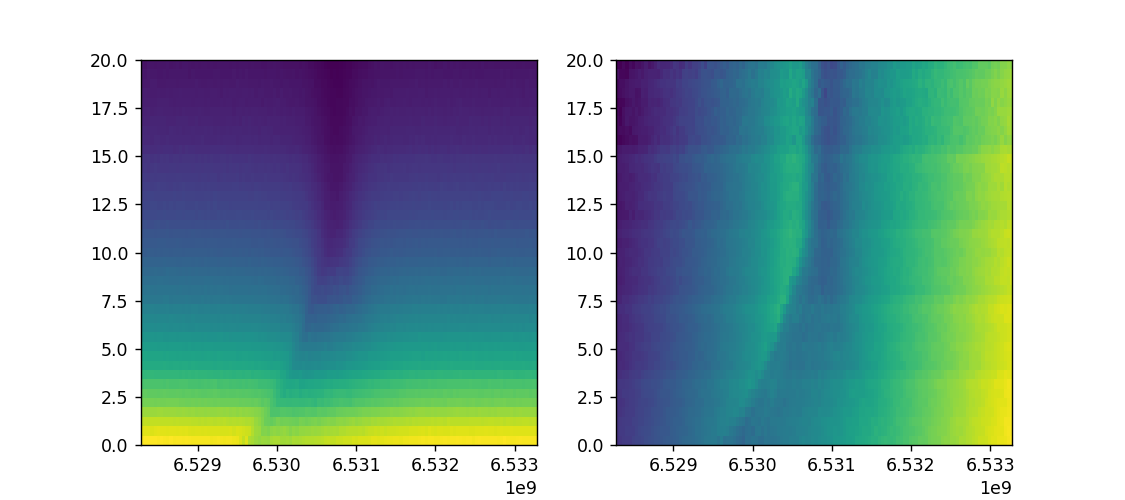

In [326]:
q_target, att = q3, np.linspace(0,20,41)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mr.S21vsPower, (q_target,measure,att,'com7',True), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespce

In [83]:
await dc[q2.inst['dc']].DC(-1)
# await dc[q4.inst['dc']].DC(1)

x = sy.Symbol('x')
q_target = q1
if q_target.inst['ex_lo'] == 'psg_ex2':
    await psg_ex1.setValue('Output','OFF')
else:
    await psg_ex2.setValue('Output','OFF')
# zname, zch = [''.join((q_target.q_name,'_z'))], q_target.inst['z_ch']
# await measure.awg[q_target.inst['z_awg']].create_waveform(name=zname[0], length=250000, format=None) 
# await cw.zWave( measure.awg[q_target.inst['z_awg']],zname,zch,0)
att_single, bias = q_target.power_ex, -0
f_com = np.float(q_target.specfunc.evalf(subs={x:bias}))
print(round(f_com,3))
# await mr.RecoverInst(measure,state=q_target.state[0])
# init = [bias if q_target==j else j.T_bias[1]-j.T_bias[0]*0.5 for j in [q2,q3,q4,q5]]
# clist = np.mat(calimatrix[1:5,1:5]).I * np.mat(init).T 
# for k, j in enumerate(clist,start=2):
#     await measure.dc[globals()['q%d'%k].inst['dc']].DC(j[0,0])

3.902


com11 open...
last ATT 00.0
now ATT 10.0


Output()

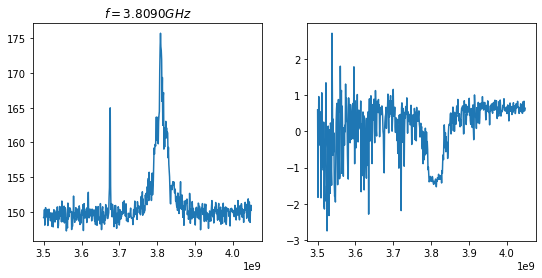

In [84]:
tag, freq = q_target.q_name, np.arange(-200,201,1)*1e6+round(f_com,3)*1e9
freq = np.arange(3.5,4.05,0.001)*1e9
# await psg_ex1.setValue('Power',0)
await dc[q_target.inst['dc']].DC(bias)
mr.Att_Setup(measure,q_target.inst['com']).Att(q_target.power_ex-50)
await cw.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
await psg_ex2.setValue('Moutput','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.singlespec, (q_target,measure,freq,True,True), tags=[tag], max=len(freq))
f_ss, s_ss = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
f_rabi = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss,np.abs(s_ss+measure.base))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[0]/1e9))
axes[1].plot(f_ss,np.angle(s_ss))
plt.show()

In [15]:
(3.811-3.676)*2

0.2699999999999996

In [86]:
q1 = q1._replace(bias=bias,f_ex=np.array([3.811e9]),state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,0,0,0,0,+0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.554940GHz,4.049000GHz,4.049000GHz,6.611080GHz,12.602000GHz
load,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0
offset,1,0,-0.023,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,1
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000dBm,0.000000dBm,13.000000dBm,18.000000dBm,-2.550000dBm


In [94]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.061, 0.064], specfunc=-69.9670512542488*cos(0.085479127321724*pi*x + 3.11381237448979) - 66.037563518335, bias=0.1, zpulse=None, f_lo=array([6.50504e+09]), delta=array([50000000.]), f_ex=array([3.877e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=13, pi_len=62.285, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z'}, 'dc02': {'offset': 0.0, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.1, 'load': 'high Z'}, 'dc06': {'offset': 0.0, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.0, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 0.0, 'load': 'high Z'}, 'dc15': {'offset': 0.0, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.555040GHz', 'power': '13.000000dBm', '

In [87]:
q1 = q1._replace(inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': [1], 'ex_awg': 'awg133', 'ex_ch': [1,2], 'ex_lo': 'psg_ex1', 'com': 'com11'},delta_ex=np.array([80e6]),power_ex=60)

## 单条谱扫电压

In [ ]:
tag, ftarget, biaslist = q_target.q_name, 3.75e9, np.arange(-0.02,0.02,0.001) + bias

att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_ex)
await mr.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.specbias, (q_target,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[0]/1e9))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# Rabi

In [88]:
q_target = q1
if q_target.inst['ex_lo'] == 'psg_ex2':
    t_rabi = np.linspace(1,801,201)
    att_single = 5
    await psg_ex1.setValue('Output','OFF')
else:
    t_rabi = np.linspace(1,1001,201)
    att_single = 0
    await psg_ex2.setValue('Output','OFF')
await measure.awg['awgread'].stop()
await measure.awg[q_target.inst['ex_awg']].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence_rabi')))
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

com11 open...
last ATT 10.0
now ATT 00.0


Output()

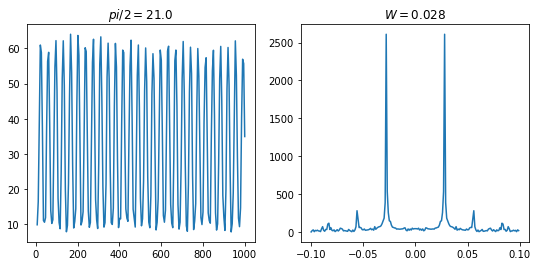

In [90]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
# await psg_ex1.setValue('Moutput','ON')
await psg_ex1.setValue('Power',0)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await psg_ex1.setValue('Moutput','OFF')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)-1),awg=1)
job = Job(mr.rabi, (q_target,measure,t_rabi,(len(t_rabi)-1),True,1), tags=[tag], max=500,avg=True)
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
x, y = t_r[:,0], np.abs(s_r[:,0])
t_op = op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.7)
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,y)
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [121]:
q1 = q1._replace(pi_len=21,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,0,0,0,0,+0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.554980GHz,3.891000GHz,4.049000GHz,6.611080GHz,12.602000GHz
load,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
offset,1,0,-0.026,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,1
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000dBm,0.000000dBm,13.000000dBm,18.000000dBm,-2.350000dBm


In [62]:
await psg_ex1.setValue('Power',3)
# mr.Att_Setup(measure,'com12').Att(0)

# pi脉冲振幅

In [34]:
q_target = q1
if q_target.inst['ex_lo'] == 'psg_ex2':
    t_rabi = np.linspace(1,801,201)
    att_single = 0
    await psg_ex1.setValue('Output','OFF')
else:
    t_rabi = np.linspace(1,1001,201)
    att_single = 0
    await psg_ex2.setValue('Output','OFF')
await measure.awg['awgread'].stop()
await measure.awg[q_target.inst['ex_awg']].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence_rabi')))
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

com11 open...
last ATT 10.0
now ATT 00.0


Output()

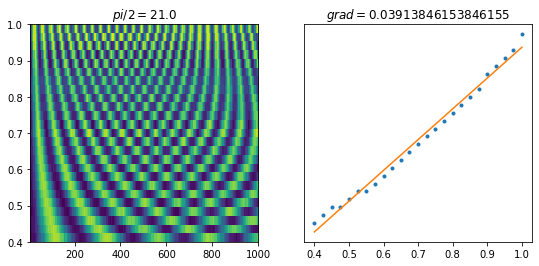

In [35]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex1.setValue('Power',0)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await psg_ex1.setValue('Moutput','OFF')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)-1),awg=1)
job = Job(mr.pipulseAmp, (q_target,measure,t_rabi), tags=[tag], max=25)
amp_pi, t_amp, s_amp = await job.done()
state = await mr.QueryInst(measure)
x, y , s = amp_pi[:,0], t_amp[0][:,0], s_amp[:,:,0]
wlist = [((op.Cos_Fit().guessCos(y,np.abs(i)))[2]) for i in s]
t_op = op.RowToRipe().firstMax(y,np.abs(s[-1]),num=0,peakpercent=0.7)
a = np.polyfit(x,wlist,1)
z = np.poly1d(a)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].set_yticks(x)
axes[1].plot(x,wlist,'.')
axes[1].plot(x,z(x))
axes[1].set_title(f'$grad={a[0]}$')
plt.show()

In [27]:
np.shape(t_amp[0])

(200, 1)

# rabi_waveform

com12 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


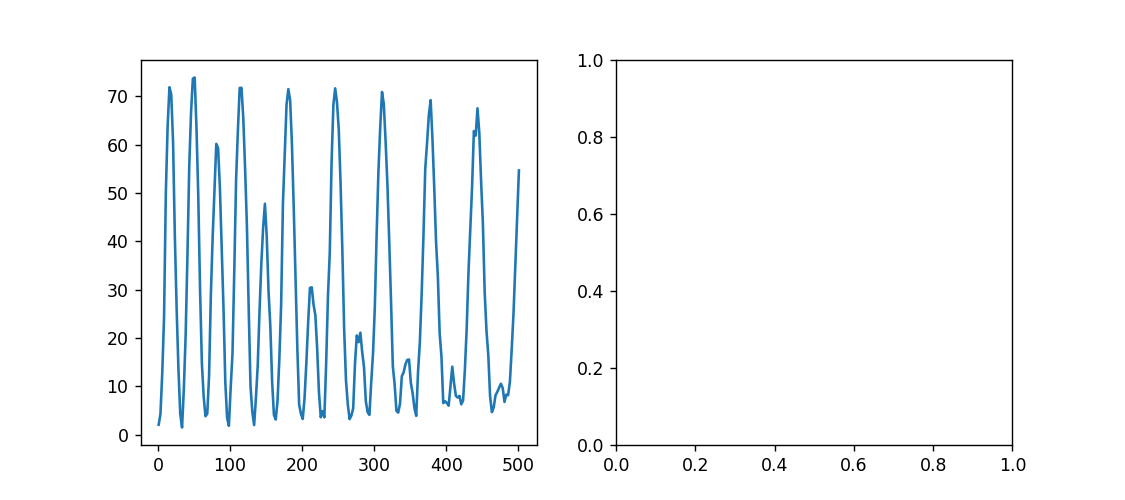

In [25]:
t_rabi, q_target, which = np.linspace(1,501,201), q3, 1
att_single = 20
if q_target.inst['ex_lo'] == 'psg_ex2':
    await psg_ex1.setValue('Output','OFF')
else:
    await psg_ex2.setValue('Output','OFF')
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex+220e6)[0])
job = Job(mr.Rabi_waveform, (q_target,measure,t_rabi,1), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

# rabiPower

com13 open...
DS Instruments,DAT64H,372,V9.10
last ATT 10.0
now ATT 05.0


Output()

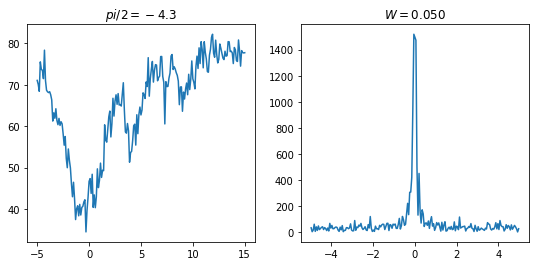

In [117]:
att, q_target = np.linspace(-5,15,201), q5

mr.Att_Setup(q_target.inst['com']).Att(5)
await psg_ex1.setValue('Moutput','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPower, (q_target,measure,att), tags=[tag], max=len(att))
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op = op.RowToRipe().firstMax(t_r[:,0],np.abs(s_r[:,0]),num=0)
sample = (np.max(t_r[:,0]) - np.min(t_r[:,0]))/(len(t_r[:,0]) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(s_r[:,0]))) / sample
amp = np.fft.fftshift(np.fft.fft(s_r[:,0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,np.abs(s_r))
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [ ]:
q3 = q3._replace(pi_len=20,power_rabi=t_op,state=[state,measure.delta,measure.base,measure.readlen])

# Readout point

com11 open...
last ATT 00.0
now ATT 00.0


Output()

<IPython.core.display.Javascript object>


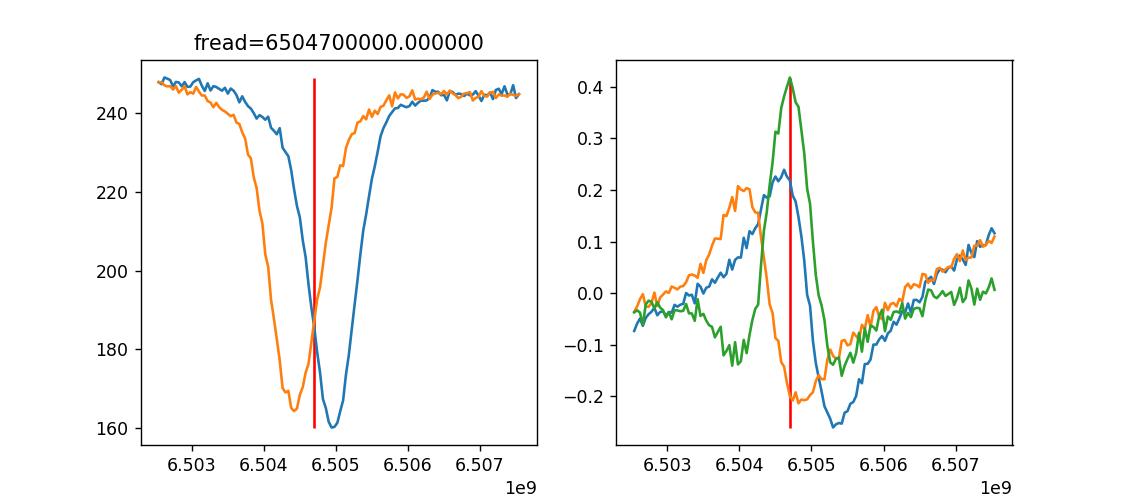

In [183]:
q_target = q1
att_setup = mr.Att_Setup(measure,q_target.inst['com'])
att_setup.Att(q_target.power_rabi)
# await mr.RecoverInst(measure,state=q_target.state[0])
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.readOp, (q_target,measure,True), tags=[tag], max=2)
st, f_op, s_op = await job.done()
f, s_off, s_on = f_op[:,:,0][0], s_op[:,:,0][0], s_op[:,:,0][1]
x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
index = np.abs(anglediff).argmax(axis=0)
#index = np.abs(s_off).argmin(axis=0)
f_lo = f[index]
measure.f_lo = np.array([f_lo])
await psg['psg_lo'].setValue('Frequency',(f_lo+measure.delta[0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_op[:,:,0].T,np.abs(s_op[:,:,0].T))
axes[0].set_title('fread=%f'%f_lo)
axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,0].T)),np.min(np.abs(s_op[:,:,0].T)),'r')
axes[1].plot(x_off,np.angle(y_off[0]))
axes[1].plot(x_on,np.angle(y_on[0]))
axes[1].plot(x_off,anglediff)
axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()

# 优化读出长度

Output()

<IPython.core.display.Javascript object>


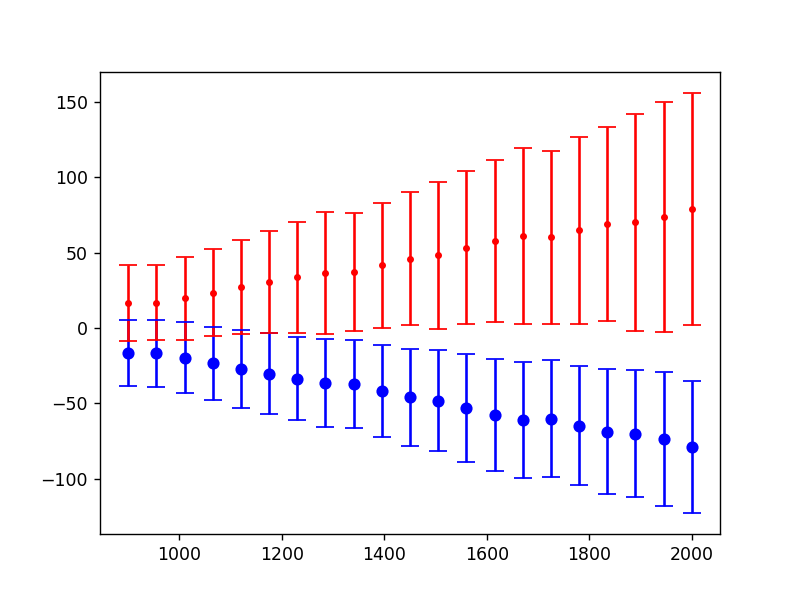

In [71]:
# await measure.psg['psg_lo'].setValue('Power',13)
# mr.Att_Setup(measure,'com7').Att(13)
job = Job(mr.readWavelen, (q_target,measure), tags=[tag], max=21)
wl, s_wl = await job.done()
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

In [251]:
4*np.sqrt(np.log(2))

3.3302184446307908

In [ ]:
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

# 临界线

In [277]:
await psg_ex1.setValue('Frequency',4.066e9)

<IPython.core.display.Javascript object>


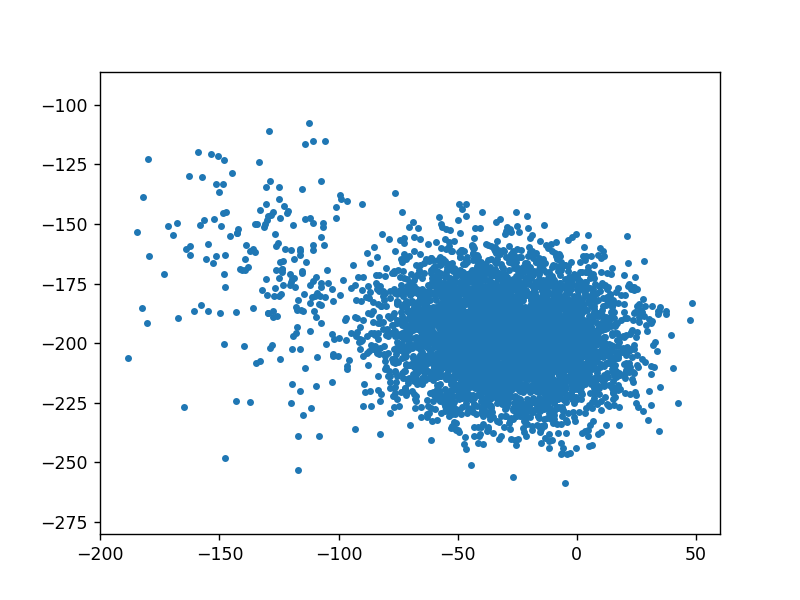

In [188]:
q_target = q1
# await measure.psg['psg_lo'].setValue('Power',13)
mr.Att_Setup(measure,'com7').Att(12)
job = Job(mr.threshHold, (q_target,measure,True), tags=[tag], max=2)
st, s_st = await job.done()
s_off, s_on = s_st[0], s_st[1]
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

In [470]:
x, y = s_st[0][:,0], s_st[1][:,0]
offmean, onmean = np.mean(x), np.mean(y)
offstd, onstd = np.std(x), np.std(y)
theta = np.arange(0, 2*np.pi, 0.01)
roff = np.real(offmean) + offstd * np.cos(theta)
ioff = np.imag(offmean) + offstd * np.sin(theta)
ron = np.real(onmean) + onstd * np.cos(theta)
ion = np.imag(onmean) + onstd * np.sin(theta)
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].plot(roff,ioff)
ax[0].plot(ron,ion)
plt.show()

<IPython.core.display.Javascript object>


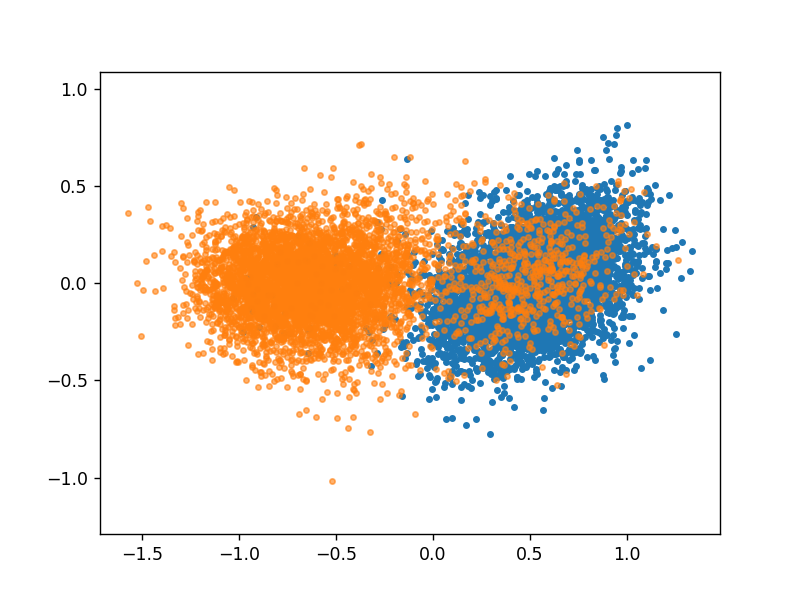

In [36]:
%matplotlib notebook
x, y = s_st[0], s_st[1]
add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
s_off, s_on = (x-add)/diff, (y-add)/diff
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

0.5367879746835443


<IPython.core.display.Javascript object>


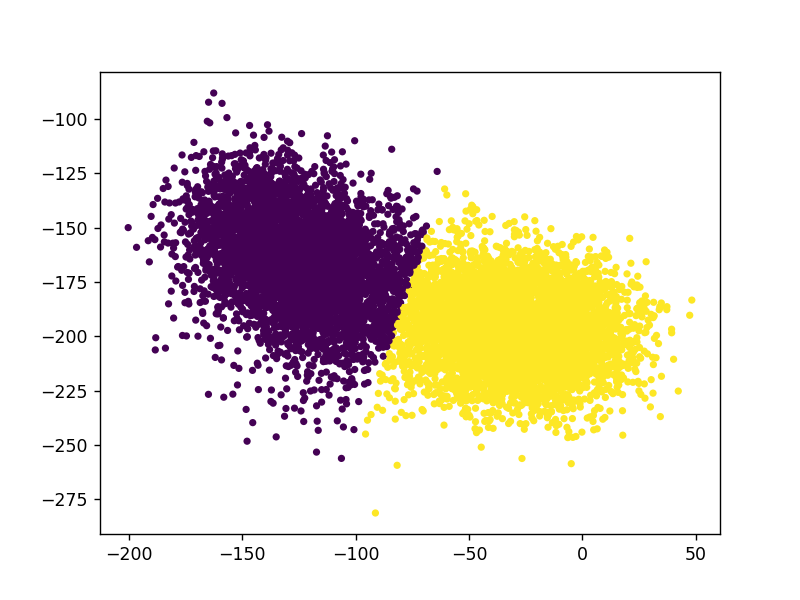

In [185]:
S = list(s_off) + list(s_on)
S = np.array(S)
x,z = np.real(S), np.imag(S)
d = list(zip(x,z))
d = np.mat(d)
kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
kmeans.fit(d)
measure.predict = kmeans.predict
y = kmeans.predict(d)
print(list(y).count(1)/len(y))
plt.figure()
plt.scatter(x,z,c=y,s=10)
plt.show()

0.8676819620253164


<IPython.core.display.Javascript object>


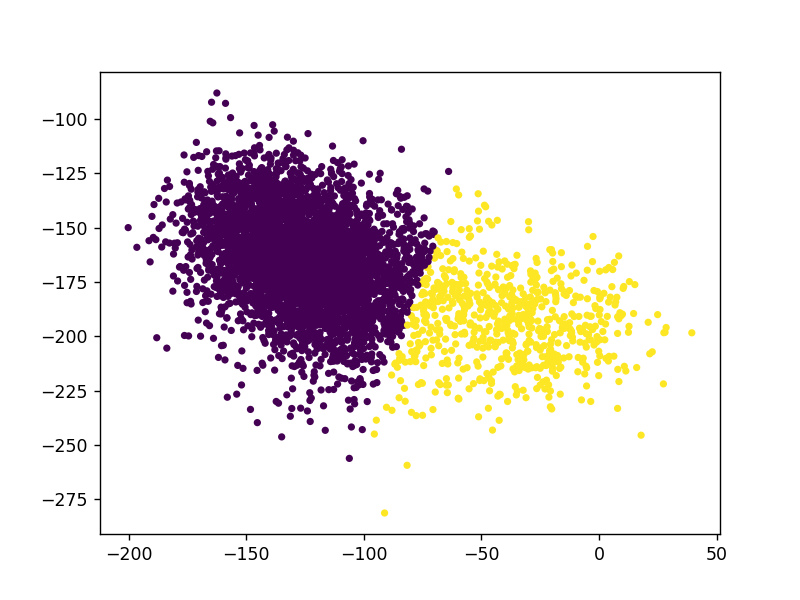

In [187]:
ss, which = s_on, 0
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# rabiPopulation

com13 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


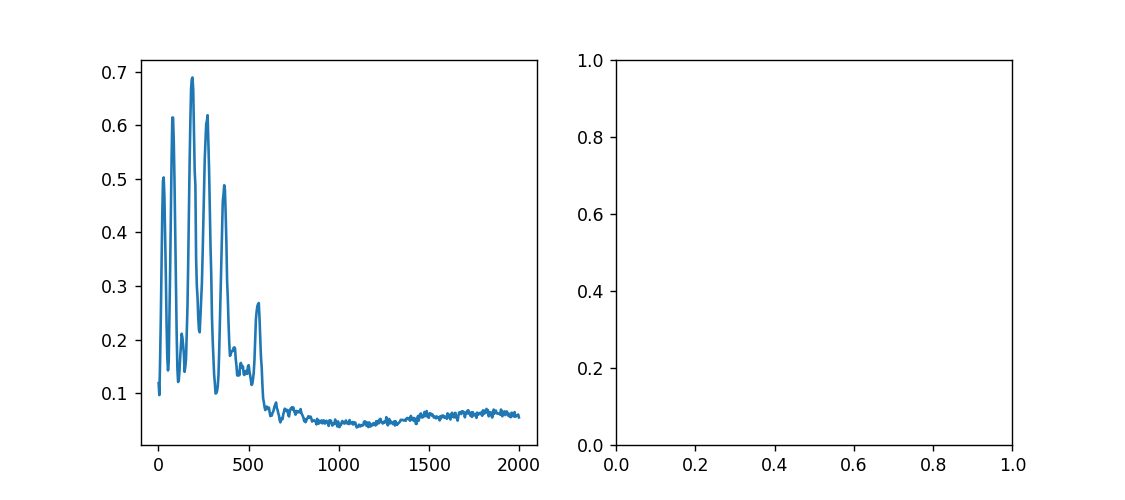

In [98]:
t_rabi, q_target, which = np.linspace(1,2001,501), q3, 1
att_single = 20
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex2.setValue('Output','OFF')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPop, (q_target,measure,t_rabi,which), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

0.10700158227848101


<IPython.core.display.Javascript object>


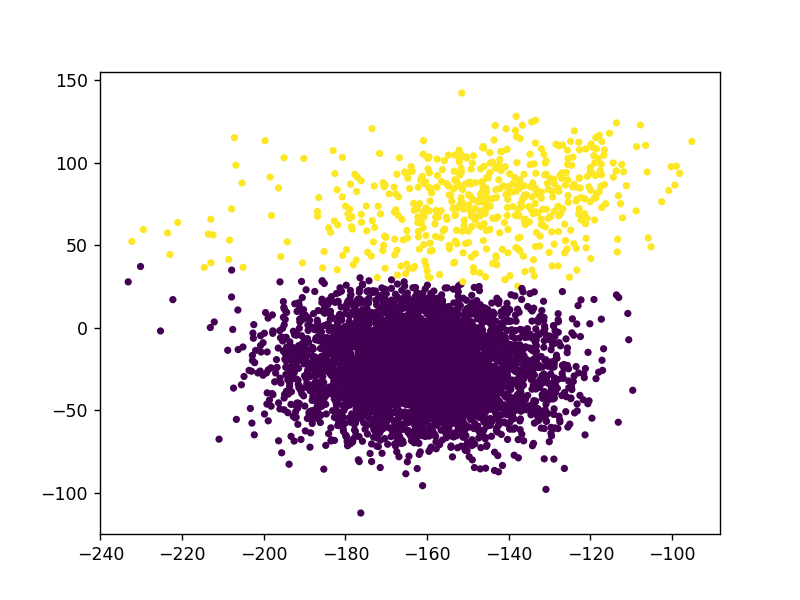

In [148]:
ss, which = pop[4,:,0], 1
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# 优化读出功率

In [191]:
com, att = 'com7', np.linspace(8,20,25)
job = Job(mr.readpowerOpt, (q_target,measure,com,att), tags=[tag], max=len(att))
attopt, popoff, popon = await job.done()
plt.figure()
plt.plot(attopt,popoff)
plt.plot(attopt,popon)
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

# pi脉冲优化

In [168]:
q_target, nwave, wavlen = q1, 10, len(t_rabi)
tag = q_target.q_name
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt, (q_target,measure,nwave,wavlen), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
y = np.array([op.RowToRipe().firstMax(y,z,num=index,peakpercent=0.7,insitu=True) for z in s])
axes[0].scatter(y[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(y),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(y))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

In [173]:
q1 = q1._replace(pi_len=18,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

In [162]:
y[np.argmax(np.abs(s),axis=1)[0]]

IndexError: index 63 is out of bounds for axis 0 with size 10

# pipulseDetune

In [192]:
q_target, which, alpharatiodelta = q1, 1, /(-270e6)
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.detuneOpt, (q_target,measure,which,alpharatiodelta), tags=[tag], max=401)
f_op, pop = await job.done()
x, y = f_op[:,0], pop[:,0]
f01 = op.RowToRipe().firstMax(x,y,num=(q_target.f_ex+q_target.delta_ex)[0],peakpercent=0.7)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_op[:,0],np.abs(pop[:,0]))
axes[0].set_title('f01=%.4f GHz'%(f01-q_target.delta_ex)/1e9)
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

# IQ-Mixer优化相位

Output()

<IPython.core.display.Javascript object>


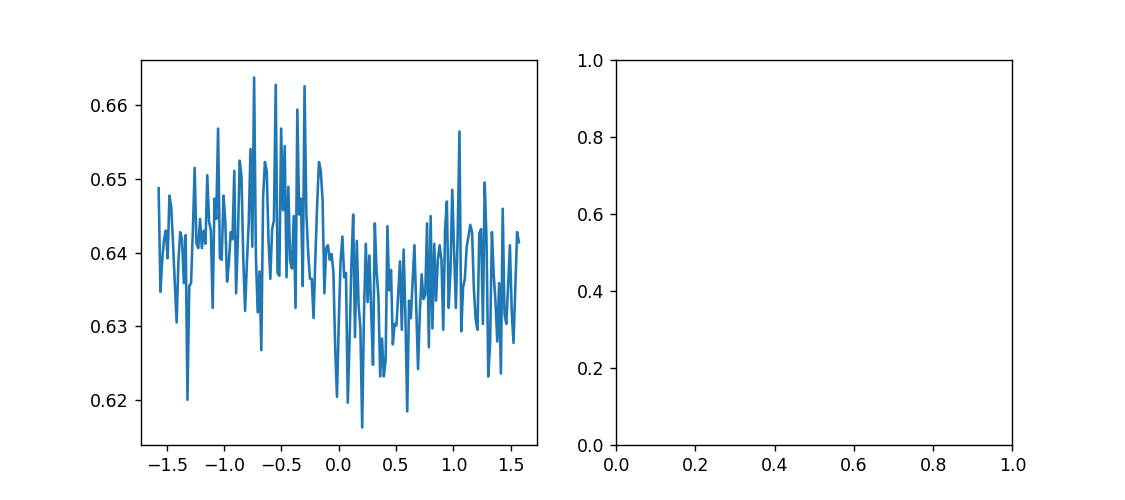

In [129]:
q_target, which = q3, 1
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.IQphaseOpt, (q_target,measure,which), tags=[tag], max=201)
phase_op, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(phase_op[:,0],np.abs(pop[:,0]))
plt.show()

In [84]:
await psg_ex1.setValue('Frequency',4.0576e9)

# AllXY dragdetune

In [193]:
q_target, which, alpha = q1, 1, -270e6
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.AllXYdragdetune, (q_target,measure,which,alpha), tags=[tag], max=82)
fall, sall = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(fall)[0]//2
axes[0].plot(fall[:l,:],np.abs(sall[:l,:]))
axes[0].plot(fall[l:,:],np.abs(sall[l:,:]))
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

In [97]:
np.shape(fall[])

(802, 1)

# AC-Stark

In [ ]:
t_ac, q_target = np.linspace(2500,4500,51), q4
job = Job(mr.acStark, (q_target,measure,t_ac), tags=[tag], max=len(t_ac))
t_AC, f_AC, s_AC = await job.done()
# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_AC,np.abs(s_AC))
# axes[1].plot(t_AC,np.angle(s_AC))
# plt.show()

In [ ]:
q7 = q7._replace(inst={'dc': 'dc08', 'z_awg': 'awg131', 'z_ch': 7, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'})

In [ ]:
q6

## ZPulse与激励时序

In [ ]:
t_z, q_target = np.linspace(500,2500,51), q6
measure.delta,measure.base,measure.readlen = q_target.state[1:]
await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.zPulse, (q_target,measure,t_z), tags=[tag], max=len(t_z))
t_AC, f_AC, s_AC = await job.done()

## 单条

In [ ]:
t_z, q_target = np.linspace(500,2500,501), q3
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.zPulse_pop, (q_target,measure,t_z), tags=[tag], max=len(t_z))
t_AC, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_AC[:,0],np.abs(pop[:,0]))
plt.show()

In [ ]:
np.savez(r'C:\Users\23967\Desktop\spec\z-pulse.npz',x=t_AC[:,0],y=np.abs(pop[:,0]))

# T1

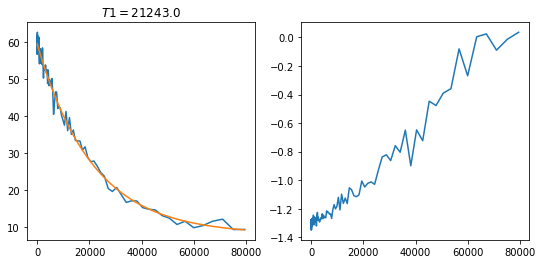

In [94]:
# t_T1, q_target = np.logspace(0,4.9,201,endpoint=True), q1
# await psg_ex1.setValue('Moutput','OFF')
# job = Job(mr.T1, (q_target,measure,t_T1,(len(t_T1)-1),True), tags=[tag], max=500,avg=True)
# t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1f$'%(1/T1))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

In [ ]:
q1 = q1._replace(T1=T1)

In [41]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.15, zpulse=None, f_lo=array([6.53062e+09]), delta=array([50000000.]), f_ex=array([3.714e+09]), delta_ex=array([0]), power_ex=30, power_rabi=4, pi_len=15.0, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': -0.024, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': -0.15, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0525, 'load': 'high Z', 'error': '+0'}, 'dc15': {'offset

# Ramsey

In [103]:
t_Ramsey, q_target = np.linspace(0,10000,201), q1
# if q_target.inst['ex_lo'] == 'psg_ex2':
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
await measure.awg['awgread'].stop()
await measure.awg[q_target.inst['ex_awg']].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence')))
measure.wave['Read'] = [['Readout_I']*len(t_Ramsey),['Readout_Q']*len(t_Ramsey)]

In [ ]:
# %matplotlib notebook
await psg_ex2.setValue('Moutput','OFF')
# mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
#await psg[q_target.inst['ex_lo']].setValue('Power',q_target.power_rabi)
job = Job(mr.Ramsey, (q_target,measure,t_Ramsey,(len(t_Ramsey)-1),True), tags=[tag], max=500,avg=True)
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], (s_ram[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

Output()

In [138]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))

In [15]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex1', 'com': 'com8'}, T_bias=[1.762, 0.064], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.1, zpulse=None, f_lo=array([6.53078e+09]), delta=array([50000000.]), f_ex=array([3.97488264e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=60, pi_len=19.5, T1=23016.178849233776, state=[{'dc01': {'offset': 1.0, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': 0.015, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': -0.1, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0, 'load': 'high Z', 'error': '+0'}, 'dc15': {'

In [140]:
q1 = q1._replace(f_ex=(np.array([f-w*1e9])-80e6+3e6))

# SpinEcho

In [27]:
t_spin, q_target = np.linspace(0,10000,201), q5
# if q_target.inst['ex_lo'] == 'psg_ex2':
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence')))
measure.wave['Read'] = [['Readout_I']*len(t_spin),['Readout_Q']*len(t_spin)]

Output()

(13.945511155644924, 25.00676961501139, 20000, 3613.257951797964, 0.0012, 0)


<IPython.core.display.Javascript object>


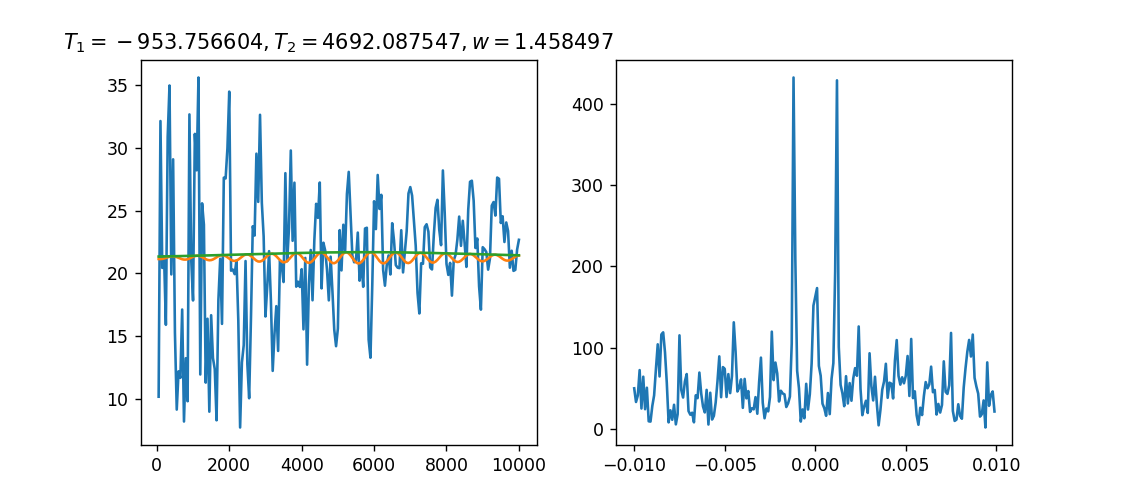

In [28]:
await psg_ex1.setValue('Moutput','ON')
# mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
#await psg[q_target.inst['ex_lo']].setValue('Power',q_target.power_rabi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.SpinEcho, (q_target,measure,t_spin,(len(t_spin)-1),1,'CPMG',True), tags=[tag], max=500,avg=True)
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], s_sp[:,0]
A,B,T1,T2,w,phi = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_sp,np.abs(s_sp))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

# CrossTalk矫正

In [ ]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [ ]:
z_crosstalk

# 普矫正

In [ ]:
v_rabi = np.linspace(-0.04,0.04,201)
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len(v_rabi),['Readout_Q']*len(v_rabi)]

In [ ]:
bits = [q2,q3,q4,q5]
count = 0
for v, k in enumerate(bits):
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_ex)
    await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits):
        comwave = True if count == 0 else False
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.crosstalkSpec, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),comwave), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await mr.InitInst(measure,psgdc=False,awgch=True)
            count += 1
    await mr.InitInst(measure,psgdc=True,awgch=True)

In [ ]:
measure.n = 1

# 二维谱

In [ ]:
freq = np.arange(3.45,4.05,0.001)*1e9
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
bits_target = bits[:3]
for k, i in enumerate(bits_target):
    att_setup = mr.Att_Setup(measure,i.inst['com'])
    att_setup.Att(i.power_ex)
    await mr.jpa_switch(measure,'ON')
    await awg133.output_on(ch=7)
    await awg133.output_on(ch=8)
    print(i.q_name)
    init = [1 if i.q_name==j.q_name else 0 for j in bits_target]
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    if k == 0:
        await dc[bits_target[k+1].inst['dc']].DC(1)
    elif k == len(bits_target)-1:
        await dc[bits_target[k-1].inst['dc']].DC(1)
    else:
        await dc[bits_target[k-1].inst['dc']].DC(1)
        await dc[bits_target[k+1].inst['dc']].DC(1)
    job = Job(mr.spec2d, (qubits,measure,freq,1,init,True), tags=[i.q_name], max=31)
    v_s2, f_s2, s_s2 = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

com8 open...
last ATT 30.0
now ATT 30.0
q1


Output()

com8 open...
last ATT 30.0
now ATT 30.0
q2


Output()

In [ ]:
np.linspace(-q3.T_bias[0]*0.3,q3.T_bias[0]*0.3,31) + q3.T_bias[1] 

In [ ]:
q3.T_bias

# RB 

In [76]:
mlist, q_target, len_data = np.logspace(0.4,2.5,21,dtype=int), q3, 41
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len_data,['Readout_Q']*len_data]

In [77]:
gate = None
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB, (q_target,measure,mlist,len_data,gate,True), tags=[tag],no_bar=True)
n_RB, s_RB = await job.done()

Output()

In [78]:
pop = []
for j in range(np.shape(s_RB)[0]):
    s = np.array(s_RB[j])
    pm = []
    for i in range(np.shape(s)[1]):
        d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
        y = measure.predict(d)
        pm.append(list(y).count(0)/len(y))
    pop.append(pm)

<IPython.core.display.Javascript object>


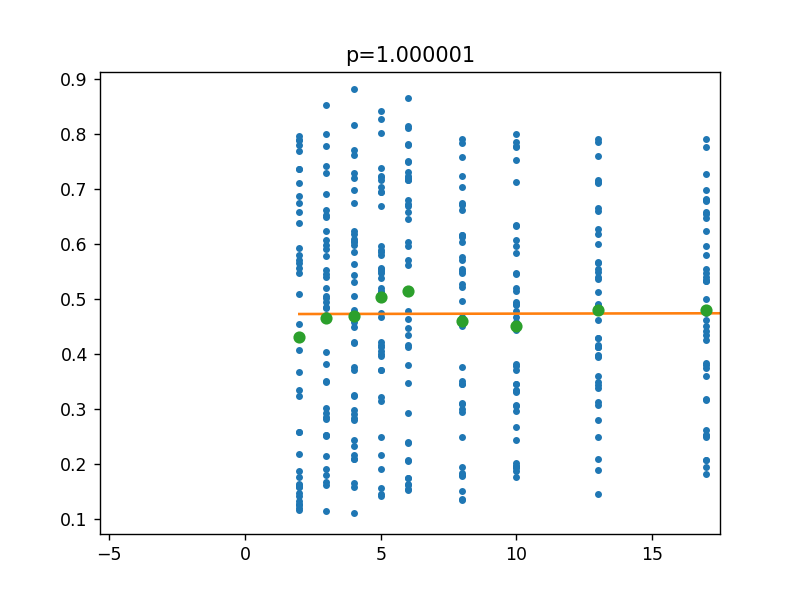

In [79]:
#n_RB = [1,5,10,20,50,100,150]
x = np.meshgrid(range(np.shape(pop)[1]),n_RB)[1]
plt.figure()
plt.plot(x.flatten(),np.array(pop).flatten(),'.')
plt.show()

In [32]:
def err(paras,x,y):
    A,B,p = paras
    return A*p**x+B-y
def guess(x,y):
    B = np.min(y)
    y = y - np.min(y)
    mask = y > 0
    a = np.polyfit(x[mask], np.log(y[mask]), 1)
    return np.exp(np.abs(a[1])), B, 1/np.exp(np.abs(a[0]))

In [33]:
x, y = n_RB, np.abs(np.mean(pop,axis=1))
p0 = guess(x,y)
res = ls(err, p0, args=(x, y)) 
A,B,p = res.x
fig = plt.gcf()
ax = plt.getp(fig,'axes')
z = A*p**x+B
ax[0].plot(x,z)
ax[0].plot(x,y,'o')
ax[0].set_title('p=%f'%p)
plt.show()

NameError: name 'n_RB' is not defined

In [ ]:
i = 20
s = np.array(s_RB[0])
d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s[:,i]),np.imag(s[:,i]),c=y,s=10)
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(n_RB,np.abs(s_RB[:,:,0].mean(axis=1)))
axes[1].plot(n_RB,np.angle(s_RB[:,:,0].mean(axis=1)))
plt.show()

# RB_waveform

## reference

In [195]:
mlist, q_target, len_data, which = np.logspace(0.4,3,21,dtype=int), q1, 31, 1
gate = False
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,gate), tags=[q_target.q_name,'reference'],no_bar=True)
n_RBw, pop_RBw = await job.done()

Output()

<IPython.core.display.Javascript object>


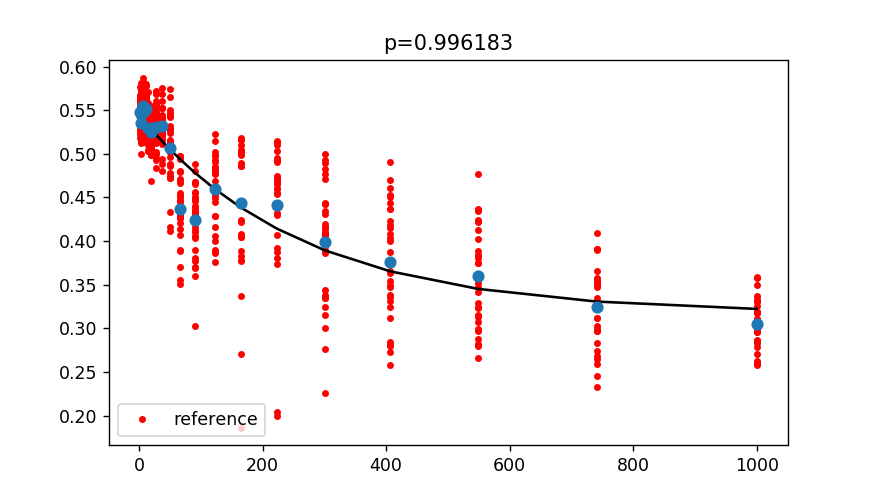

In [196]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label='reference')
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.title('p=%f'%p)
plt.show()

## gate

In [39]:
mlist, q_target, len_data, which = np.logspace(0.4,3,21,dtype=int), q1, 31, 1
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

for gate in ['2','3','4','5','6','7']:
    job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,gate), tags=[q_target.q_name,gate],no_bar=True)
    n_RBw, pop_RBw = await job.done()
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

Output()

Output()

Output()

Output()

Output()

Output()

<IPython.core.display.Javascript object>


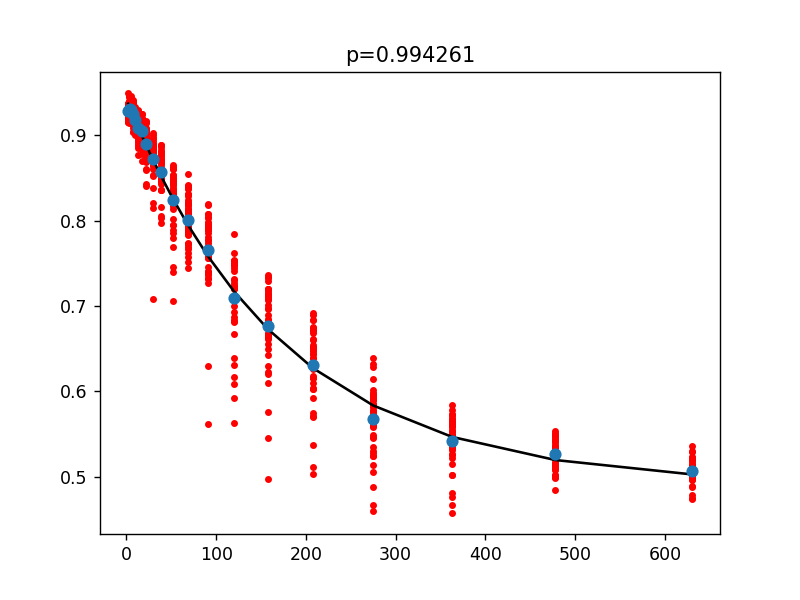

In [64]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label=gate)
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.set_title('p=%f'%p)
plt.show()

In [70]:
Pref, Pgate, d = 0.9946, 0.994261, 2**(1)
Rgate = (1-Pgate/Pref)*(1-1/d)
Rgate

-0.003516601051131496

# 单比特tomo

In [58]:
q_target, which = q3, 1
t_rabi = np.linspace(1,1001,201)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.tomo, (q_target,measure,t_rabi,which), tags=[q_target.q_name], max=len(t_rabi))
t_tomo, poplist = await job.done()
# s_off, s_on = s_st[0], s_st[1]
# plt.figure()
# plt.plot(np.real(s_off),np.imag(s_off),'.')
# plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
# plt.axis('equal')
# plt.show()

Output()

In [59]:
poplist

array([[0.5181962 , 0.58643196, 0.04549051],
       [0.58821203, 0.78995253, 0.16159019],
       [0.63488924, 0.89893196, 0.38508703],
       [0.62935127, 0.86293513, 0.63825158],
       [0.59810127, 0.72250791, 0.81606013],
       [0.5494462 , 0.47626582, 0.89537184],
       [0.50336234, 0.25019778, 0.84869462],
       [0.44818038, 0.08761867, 0.66712816],
       [0.40981013, 0.03461234, 0.43908228],
       [0.41811709, 0.13488924, 0.2213212 ],
       [0.46340981, 0.33445411, 0.06388449],
       [0.51206487, 0.55735759, 0.04272152],
       [0.58306962, 0.77037184, 0.14992089],
       [0.63508703, 0.89082278, 0.36016614],
       [0.64220728, 0.85838608, 0.59078323],
       [0.60858386, 0.72646361, 0.79549051],
       [0.56784019, 0.50217563, 0.88864715],
       [0.50593354, 0.25178006, 0.83386076],
       [0.44996044, 0.09236551, 0.6940269 ],
       [0.40486551, 0.04450158, 0.46064082],
       [0.41119462, 0.12401108, 0.22666139],
       [0.45470728, 0.29568829, 0.08306962],
       [0.

In [60]:
[[1-2*j[i] for i in range(3)] for j in poplist]

[[-0.03639240506329111, -0.1728639240506329, 0.9090189873417721],
 [-0.17642405063291133, -0.5799050632911393, 0.6768196202531646],
 [-0.2697784810126582, -0.7978639240506329, 0.22982594936708856],
 [-0.25870253164556956, -0.7258702531645569, -0.276503164556962],
 [-0.19620253164556956, -0.4450158227848102, -0.6321202531645569],
 [-0.09889240506329111, 0.04746835443037978, -0.790743670886076],
 [-0.006724683544303778, 0.4996044303797469, -0.6973892405063291],
 [0.10363924050632911, 0.8247626582278481, -0.334256329113924],
 [0.180379746835443, 0.9307753164556962, 0.12183544303797467],
 [0.1637658227848101, 0.7302215189873418, 0.5573575949367089],
 [0.07318037974683544, 0.3310917721518988, 0.8722310126582279],
 [-0.02412974683544311, -0.11471518987341778, 0.9145569620253164],
 [-0.1661392405063291, -0.540743670886076, 0.7001582278481013],
 [-0.27017405063291133, -0.7816455696202531, 0.27966772151898733],
 [-0.28441455696202533, -0.7167721518987342, -0.18156645569620244],
 [-0.21716772151